# 朴素贝叶斯模型实验 （选作）

> 本实验目标是用朴素贝叶斯模型对Yelp网站的评论文本进行分类

## 第一步：读入数据

把`yelp.csv`读入一个DataFrame中。

In [66]:
# read csv
import pandas as pd

url = "e2.4_yelp.csv"
yelp = pd.read_csv(url)
yelp.head()

business_id        date               review_id  stars  \
0  9yKzy9PApeiPPOUJEtnvkg  2011-01-26  fWKvX83p0-ka4JS3dc6E5A      5   
1  ZRJwVLyzEJq1VAihDhYiow  2011-07-27  IjZ33sJrzXqU-0X6U8NwyA      5   
2  6oRAC4uyJCsJl1X0WZpVSA  2012-06-14  IESLBzqUCLdSzSqm0eCSxQ      4   
3  _1QQZuf4zZOyFCvXc0o6Vg  2010-05-27  G-WvGaISbqqaMHlNnByodA      5   
4  6ozycU1RpktNG2-1BroVtw  2012-01-05  1uJFq2r5QfJG_6ExMRCaGw      5   

                                                text    type  \
0  My wife took me here on my birthday for breakf...  review   
1  I have no idea why some people give bad review...  review   
2  love the gyro plate. Rice is so good and I als...  review   
3  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...  review   
4  General Manager Scott Petello is a good egg!!!...  review   

                  user_id  cool  useful  funny  
0  rLtl8ZkDX5vH5nAx9C3q5Q     2       5      0  
1  0a2KyEL0d3Yb1V6aivbIuQ     0       0      0  
2  0hT2KtfLiobPvh6cDC8JQg     0       1      0  
3  uZetl9T0NcROGOyFfughhg     1       2      0  
4  vYmM4KTsC8ZfQBg-j5MWkw     0       0      0

创建一个新的DataFrame，只包含5颗星和1颗星评分的数据。

In [67]:
# filter data
yelp_best_worst = yelp[(yelp.stars==5) | (yelp.stars==1)]


## 第二步：生成X和y

使用评论文本作为唯一的分类特征，评分星数作为预测目标，并将数据集划分为训练集和测试集。

In [68]:
# define X and y 
X = yelp_best_worst.text
y = yelp_best_worst.stars


In [69]:
# split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)



## 第三步：转换数据

使用CountVectorizer将X_train和X_test转换为document-term矩阵。

In [70]:
# import and instantiate the vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [71]:
# fit and transform X_train, but only transform X_test
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

## 第四步：训练、预测、评价

使用朴素贝叶斯预测测试集中评论的星级评分，并计算预测精度。

In [72]:
# import/instantiate/fit
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [73]:
# make class predictions
y_pred_class = nb.predict(X_test_dtm)

In [74]:
# calculate accuracy
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)


0.9187866927592955

计算AUC。注意：y_test中的取值是1和5，需要先把它转换为取值为0和1的二值数组y_test_binary。

In [75]:
# create y_test_binary from y_test, which contains ones and zeros instead
# of ones and fives
y_test_binary = y_test.map({5:1, 1:0})


In [76]:
# predict class probabilities
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

In [77]:
# calculate the AUC using y_test_binary and y_pred_prob
metrics.roc_auc_score(y_test_binary, y_pred_prob)

0.9391635104285566

绘制ROC曲线。

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

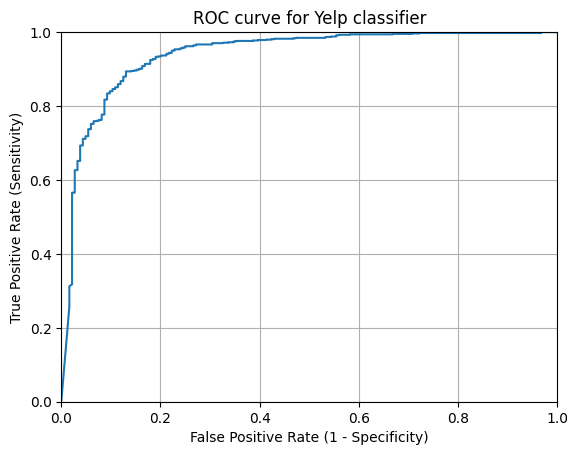

In [79]:
# plot ROC curve using y_test_binary and y_pred_prob
fpr, tpr, thresholds = metrics.roc_curve(y_test_binary, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Yelp classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

显示混淆矩阵，并计算敏感度和特异性，评论结果。

In [80]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)


array([[126,  58],
       [ 25, 813]])

In [81]:
# calculate sensitivity
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_class).ravel()
sensitivity = tp / float(tp + fn)
sensitivity

0.9701670644391408

In [82]:
# calculate specificity
specificity = tn / float(tn + fp)
specificity


0.6847826086956522

对模型的敏感度和特异性做出评论：

## 第五步：错误分析

查看测试集中一些被预测错误的评论文本，即false positives和false negatives。试着回答为什么这些评论会被预测错。

In [83]:
# first 10 false positives (meaning they were incorrectly classified as 5-star reviews)
X_test[y_pred_class > y_test]


2175    This has to be the worst restaurant in terms o...
1781    If you like the stuck up Scottsdale vibe this ...
2674    I'm sorry to be what seems to be the lone one ...
9984    Went last night to Whore Foods to get basics t...
3392    I found Lisa G's while driving through phoenix...
8283    Don't know where I should start. Grand opening...
2765    Went last week, and ordered a dozen variety. I...
2839    Never Again,\nI brought my Mountain Bike in (w...
321     My wife and I live around the corner, hadn't e...
1919                                         D-scust-ing.
2490    Lazy Q CLOSED in 2010.  New Owners cleaned up ...
9125    La Grande Orange Grocery has a problem. It can...
9185    For frozen yogurt quality, I give this place a...
436     this another place that i would give no stars ...
2051    Sadly with new owners comes changes on menu.  ...
1721    This is the closest to a New York hipster styl...
3447    If you want a school that cares more about you...
842     Boy is

In [84]:
# first 10 false negatives (meaning they were incorrectly classified as 1-star reviews)
X_test[y_pred_class < y_test]

7148    I now consider myself an Arizonian. If you dri...
4963    This is by far my favourite department store, ...
6318    Since I have ranted recently on poor customer ...
380     This is a must try for any Mani Pedi fan. I us...
5565    I`ve had work done by this shop a few times th...
3448    I was there last week with my sisters and whil...
6050    I went to sears today to check on a layaway th...
2504    I've passed by prestige nails in walmart 100s ...
2475    This place is so great! I am a nanny and had t...
241     I was sad to come back to lai lai's and they n...
3149    I was told to see Greg after a local shop diag...
423     These guys helped me out with my rear windshie...
763     Here's the deal. I said I was done with OT, bu...
8956    I took my computer to RedSeven recently when m...
750     This store has the most pleasant employees of ...
9765    You can't give anything less than 5 stars to a...
6334    I came here today for a manicure and pedicure....
1282    Loved 

## 第六步：多分类预测

使用所有的评论做预测，而不仅仅是评分1星和5星的评论。

In [85]:
# define X and y using the original DataFrame
X = yelp.text
y = yelp.stars


In [86]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)



In [87]:
# create document-term matrices
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)



In [88]:
# fit a Naive Bayes model
nb.fit(X_train_dtm, y_train)



MultinomialNB()

In [89]:
# make class predictions
y_pred_class = nb.predict(X_test_dtm)


In [90]:
# calculate the testing accuary
metrics.accuracy_score(y_test, y_pred_class)


0.4712

In [91]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)


array([[ 55,  14,  24,  65,  27],
       [ 28,  16,  41, 122,  27],
       [  5,   7,  35, 281,  37],
       [  7,   0,  16, 629, 232],
       [  6,   4,   6, 373, 443]])

有何评论：